In [1]:
import numpy as np
import scipy as sp
import scipy.special
import scipy.signal
import scipy.linalg
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
if 1:
    ## Generate test data
    # Parameters
    K = 250
    trials = 1
    sigma2e = 0.1
    varY = np.array([1., 2.5, 3.])
    C = np.array([[-1, .1], [1, 1], [-1, -1]])
    #
    x = sp.signal.lfilter([1], [1, -1], np.sqrt(sigma2e) * np.random.randn(K))
    x = x - np.linspace(0, x[-1] + np.sqrt(sigma2e) * np.random.randn(), len(x)) # make a bit like a Brownian bridge
    #dN = np.bitwise_xor.accumulate(dN, axis=0)
    dN = np.random.rand(K, trials) < np.exp(x[:,None])/(1+np.exp(x[:,None]))
    dN = np.sum(dN, axis=1).astype(float)
    dN[len(dN)//2:] = np.NaN
    Y = C[:,:1].T + np.outer(x, C[:,1]) + np.random.randn(K, len(varY)) * np.sqrt(varY)[None,:]
    Y[2*len(Y)//3:,:] = np.NaN
    ll_from_R = np.empty([0,2])

## Kalman test code

In [3]:
def Do_Kalman_Likelihood(y, sigma2obs, sigma2e):
    """MAP solution, inverse covariance matrix, and marginal loglikelihood of state-space model

    :param y: Observations (K,)
    :param sigma2obs: Variance of observation noise (can be scalar or vector)
    :param sigma2e: Variance of process noise
    :return: x_map, L, marginal_loglikelihood, joint_loglikelihood
    """
    # Build diagonals of information matrix
    sigma2obs *= np.ones(len(y))
    D = 1. / sigma2obs + 2. / sigma2e
    D[-1] = 1. / sigma2obs[-1] + 1. / sigma2e
    B = -np.ones(len(D)) / sigma2e
    B[-1] = 0.
    
    # Solve, assuming x_init=0 for simplicity
    L = sp.linalg.cholesky_banded((D, B), lower=True)
    x_map = sp.linalg.cho_solve_banded([L, True], y / sigma2obs)

    # Compute joint and marginal probabilities
    joint_loglikelihood = -.5 * ((np.sum(np.diff(x_map)**2) + x_map[0]**2) / sigma2e +
                                 np.sum((y - x_map)**2 / sigma2obs) +
                                 (len(y) * np.log(2*np.pi*sigma2e * 2*np.pi) + np.sum(np.log(sigma2obs))))
    marginal_loglikelihood = len(y)/2. * np.log(2*np.pi) + joint_loglikelihood - np.sum(np.log(L[0]))
    return x_map, L, marginal_loglikelihood, joint_loglikelihood

In [4]:
# Simple test of Do_Kalman_Likelihood only (K=1, Gaussian)
import scipy.stats as stats
y = 3.
sigma2obs = 10.
x_map, L, marginal_loglikelihood, joint_loglikelihood = Do_Kalman_Likelihood(y * np.ones(1), sigma2obs, sigma2e)
j = stats.norm.pdf(x_map, 0, np.sqrt(sigma2e)) * stats.norm.pdf(x_map, y, np.sqrt(sigma2obs))
m = np.sqrt(2*np.pi) * j / L[0,0]
assert(abs(np.log(j) - joint_loglikelihood) < 1e-9)
assert(abs(np.log(m) - marginal_loglikelihood) < 1e-9)

## Likelihood of a state-space model with Bernoulli and Gaussian observations

The log-likelihood is
\begin{align*}
\log p(N_{0,K}, x; \theta) &= \log p(N_{0,K}|x) + \log p(Y|x,\theta) + \log p(x; \theta) \\
&= \sum\limits_{k=1}^{K} \log p(\Delta N_{k}|x_k) + \sum\limits_{k=1}^{K} \log p(Y_{k}|x_k,\theta) + \sum\limits_{k=1}^{K} \log p(x_k|x_{k-1}; \sigma_{\epsilon}^2) \\
&= \sum\limits_{k=1}^{K} \left[\Delta N_{k} \log\left(\frac{e^{x_k}}{1+e^{x_k}}\right) + (1-\Delta N_{k}) \log\left(\frac{1}{1+e^{x_k}}\right) \right] + \eta(Y, x; \theta) + \pi(x; \theta)\\
&= \sum\limits_{k=1}^{K} \left[ \Delta N_{k} \, x_k - \log(1+e^{x_k}) \right] + \eta(Y, x; \theta) + \pi(x; \theta)
\end{align*}
where
\begin{align*}
\pi(x; \theta) &= - \frac{K}{2} \log(2\pi\sigma_{\epsilon}^2) - \frac{1}{2\sigma_{\epsilon}^2} \sum\limits_{k=1}^{K} (x_k - x_{k-1})^2\\
\eta(Y, x; \theta) &= - \frac{K}{2} \log(2\pi) - \frac{K}{2}\log\lvert R \rvert - \frac12 \sum\limits_{k=1}^{K} (\beta_0 + x_k \beta_1 - Y_k)^T R^{-1} (\beta_0 + x_k \beta_1 - Y_k)
\end{align*}

## Laplace approximation at the MAP

In [5]:
def Do_Kalman_Likelihood_Bernoulli_And_Gaussian_LaplaceMAP(dN, Y, C, varY, sigma2e, x0=0., tol=1e-8, trials=1.):
    """MAP solution, inverse covariance matrix, and marginal loglikelihood of state-space model
    computed using Laplace approximation around MAP state.

    :param dN: Binomial (or Bernoulli) observations (K,)
    :param Y: Gaussian observations (K,M)
    :param C: Coefficients of Gaussian observations Y_{k,m} = C_{m,0} + C_{m,1} * x_{k} (M,2)
    :param varY: Diagonal of covariance matrix of Gaussian observations (M,)
    :param sigma2e: Variance of process noise
    :param tol: Convergence criterion on the gradient of the log-likelihood
    :param trials: Number of trials for binomial observations (1 for Bernoulli)
    :return: x_map, U, marginal_loglikelihood, joint_loglikelihood
    """
    x = np.zeros(dN.shape)
    dN_pres = ~np.isnan(dN)
    dN = np.nan_to_num(dN).astype(float)
    Y_pres = ~np.isnan(Y)
    Y = np.nan_to_num(Y)
    while True:
        # Build gradient of joint
        d2x = np.convolve(x, [-1, 2, -1])[1:-1]
        d2x[-1] -= x[-1]
        d2x[0] -= x0
        G = d2x / sigma2e + dN_pres * (-dN + trials * (1. / (1. + np.exp(-x))))
        G += np.dot(Y_pres * (C[:,:1].T + np.outer(x, C[:,1]) - Y), C[:,1] / varY)
        # Build Hessian of joint
        D = 2. / sigma2e + dN_pres * (trials / (np.exp(x) + 2. + np.exp(-x))) + np.dot(Y_pres * C[:,1:].T, C[:,1] / varY)
        D[-1] -= 1. / sigma2e
        B = -np.ones(len(D)) / sigma2e
        B[0] = 0.
        U = sp.linalg.cholesky_banded((B, D), lower=False)
        # Check convergence
        if np.dot(G, G) < tol:
            x_map = x
            break
        # Update estimate of map
        x -= sp.linalg.cho_solve_banded([U, False], G)

    # Compute joint and marginal probabilities
    joint_loglikelihood = (np.dot(dN_pres, np.log(sp.special.binom(trials, dN)) + dN * x_map - trials * np.log(1 + np.exp(x_map)))
                           - .5 * (np.sum(Y_pres * (C[:,:1].T + np.outer(x, C[:,1]) - Y)**2 / varY[None,:]) + np.dot(np.sum(Y_pres, axis=0), np.log(2*np.pi*varY)))
                           - .5 * ((np.sum(np.diff(x_map)**2) + (x_map[0] - x0)**2) / sigma2e + len(x_map) * np.log(2*np.pi*sigma2e)))
    marginal_loglikelihood = len(dN)/2. * np.log(2*np.pi) + joint_loglikelihood - np.sum(np.log(U[-1]))
    return x_map, U, marginal_loglikelihood, joint_loglikelihood

In [6]:
def cov_from_chol_precision(U):
    """Given the Cholesky factorization (U) of the posterior precision matrix (J), with U^t * U = J,
    return the tridiagonal part of the covariance matrix.

    :param U: Cholesky factorization (U) of J, given as [0, A; D] where A is the upper diagonal and D the main diagonal
    :return: Cov_tri: Tridiagonal part of the covariance matrix returned as [0, C_i,i+1; C_ii; C_i+1,i, 0]
    """
    assert(U.shape[0] == 2 and U[0,0] == 0)
    A, D = U # Unpack matrix into first (above) diagonal and diagonal
    Cov_tri = np.zeros_like(U)
    C, V = Cov_tri # Obtain _views_ into the first diagonal and diagonal
    # Compute last element of diagonal
    V[-1] = 1. / (D[-1] ** 2)
    # Recursively compute other elements of main diagonal and first diagonal
    for i in range(len(D)-1, 0, -1):
        iD = 1. / D[i-1]
        iDA = iD * A[i]
        N = -iDA * V[i]
        C[i] = N
        V[i-1] = iD ** 2 - N * iDA
    return Cov_tri

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 996 µs
-970.399753605


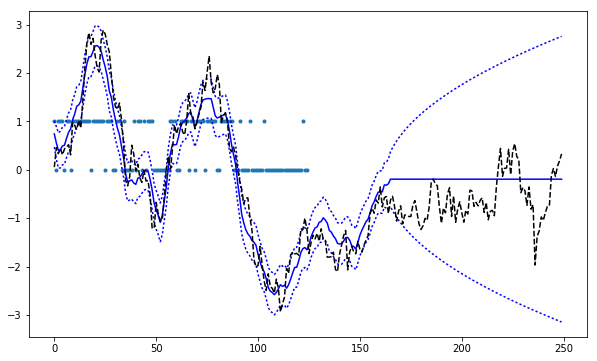

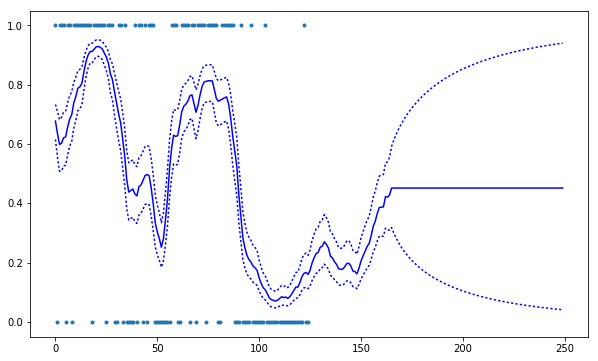

In [7]:
# Test Marginal_Likelihood using the Laplace approximation around the MAP
%time x_map_l, U_l, marginal_loglikelihood_l, joint_loglikelihood_l = Do_Kalman_Likelihood_Bernoulli_And_Gaussian_LaplaceMAP(dN, Y, C, varY, sigma2e, x0=1, trials=trials)
print(marginal_loglikelihood_l)
plt.figure(figsize=(10,6))
plt.plot(dN, '.')
std = np.sqrt(cov_from_chol_precision(U_l)[1])
x_conf_l = x_map_l[:,None] + [[-1,1]] * std[:,None]
plt.plot(x_map_l, 'b')
plt.plot(x_conf_l, 'b:')
plt.plot(x, 'k--')
plt.show()
plt.figure(figsize=(10,6))
plt.plot(dN, '.')
plt.plot(np.exp(x_map_l)/(1+np.exp(x_map_l)), 'b')
plt.plot(np.exp(x_conf_l) / (1 + np.exp(x_conf_l)), 'b:')
plt.show()

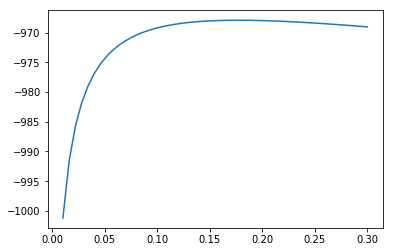

In [8]:
s2e = np.linspace(.01, .3, 50)
marginal_loglikelihood_l = np.zeros_like(s2e)
joint_loglikelihood_l = np.zeros_like(s2e)
for i in range(len(s2e)):
    marginal_loglikelihood_l[i], joint_loglikelihood_l[i] = Do_Kalman_Likelihood_Bernoulli_And_Gaussian_LaplaceMAP(dN, Y, C, varY, s2e[i], trials=trials)[2:]
plt.clf()
plt.plot(s2e, marginal_loglikelihood_l)
#plt.show()
#plt.plot(s2e, joint_loglikelihood_l)

### Expectation-maximization to optimize the parameters using the Laplace approximation at the MAP

In [9]:
def EM_fit_coefs_Laplace(dN, Y, C_init, varY_init, sigma2e_init, x0_init, tol=1e-8, max_iter=100000, trials=1.):
    """Optimize sigma2e using the EM algorithm using the Laplace approximation at the MAP.

    :param dN: Observations (K,)
    :param Y: Gaussian observations (K,M)
    :param C: Initial estimate of coefficients of Gaussian observations (M,2)
    :param varY: Initial estimate of diagonal of covariance matrix of Gaussian observations (M,)
    :param sigma2e_init: Initial estimate of sigma2e
    :param tol: Convergence criterion for the EM
    :param trials: Number of trials for binomial observations (1 for Bernoulli)
    :return: x_map, U, marginal_loglikelihood, joint_loglikelihood
    """
    Y_pres = ~np.isnan(Y)
    Y_n = np.nan_to_num(Y)
    sigma2e_old = sigma2e_init
    C_old = C_init
    varY_old = varY_init
    x0_old = x0_init
    K = len(dN)
    ml = []
    for i in range(max_iter):
        x_map, U, marginal_loglikelihood, _ = Do_Kalman_Likelihood_Bernoulli_And_Gaussian_LaplaceMAP(dN, Y, C_old, varY_old, sigma2e_old, x0_old, trials=trials)
        ml.append(marginal_loglikelihood)
        Cov_tri = cov_from_chol_precision(U)
        E_x_k = np.sum(x_map) # \sum_k E[x_k]
        E_x_k_x_k = np.sum(Cov_tri[1]) + np.dot(x_map, x_map) # \sum_k E[x_k^2]
        sigma2e = (E_x_k_x_k # E[x_k^2]
                   + np.sum(Cov_tri[1,:-1]) + np.dot(x_map[:-1], x_map[:-1]) # E[x_{k-1}^2]
                   - 2 * np.sum(Cov_tri[0]) - 2 * np.dot(x_map[1:], x_map[:-1])) / len(dN) # E[x_{k-1} * x_k]
        regr_map = np.column_stack((np.ones(K), x_map))
        Z = np.array([[np.ones(K), x_map], [x_map, Cov_tri[1] + x_map * x_map]])
        C = np.row_stack(sp.linalg.solve(np.dot(Z, Y_pres[:,j]), np.dot(regr_map.T, Y_n[:,j]), sym_pos=True) for j in range(Y.shape[1]))
        varY = np.sum(Y_pres * ((np.dot(regr_map, C.T) - Y_n)**2 + np.outer(Cov_tri[1], C[:,1]**2)), axis=0) / np.sum(Y_pres, axis=0)
        x0 = x_map[0]
        # show progress and check stopping condition
        step_sizes = (sigma2e - sigma2e_old)**2, np.sum((C - C_old)**2), np.sum((varY - varY_old)**2), (x0 - x0_old)**2
        print('{}: {:.6} , {!s:<50}'.format(i, marginal_loglikelihood, ' '.join(format(s, '.5e') for s in step_sizes)), end='\r')
        if (sum(step_sizes) < tol): break
        C_old, varY_old, sigma2e_old, x0_old = C, varY, sigma2e, x0

    print()
    return sigma2e, C, varY, x0, ml


198: -965.415 , 1.07588e-09 8.37638e-09 1.12500e-10 1.95228e-10   
sigma2e: 0.170734150236 0.1
C:
 [[-0.97733308  0.1222067 ]
 [ 1.02911994  1.03297995]
 [-1.29965003 -0.99684163]] 
 [[-1.   0.1]
 [ 1.   1. ]
 [-1.  -1. ]]
varY: [ 0.97392414  2.19141878  3.36702578] [ 1.   2.5  3. ]
x0: -0.203525879534 0


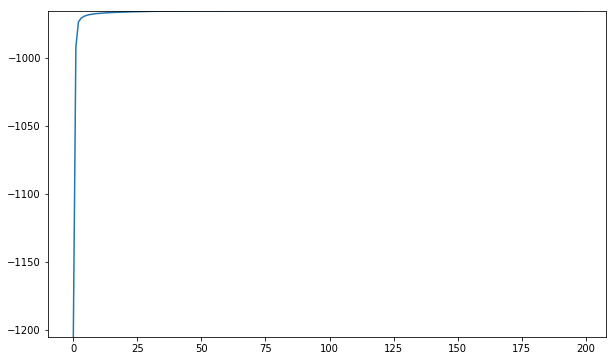

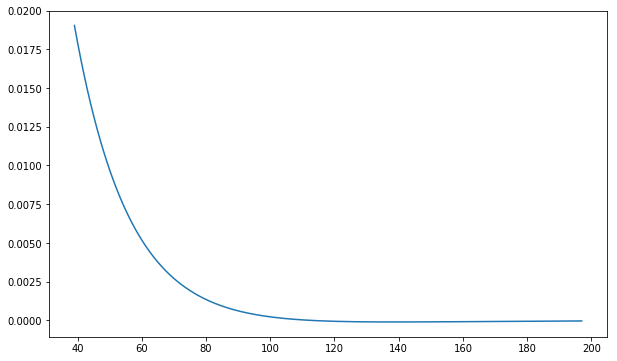

In [10]:
#%time 
sigma2e_opt, C_opt, varY_opt, x0_opt, marginal_ll = EM_fit_coefs_Laplace(dN, Y, 0*C, 5*varY, 5*sigma2e, 0, tol=1e-8, trials=trials)
print('sigma2e:', sigma2e_opt, sigma2e)
print('C:\n', C_opt, '\n', C)
print('varY:', varY_opt, varY)
print('x0:', x0_opt, 0)

plt.figure(figsize=(10,6))
plt.plot(marginal_ll)
plt.ylim((max(min(marginal_ll), marginal_ll[len(marginal_ll)//5]-1e3), max(marginal_ll)))
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(len(marginal_ll)//5, len(marginal_ll)-1), np.diff(marginal_ll[len(marginal_ll)//5:]))
plt.show()

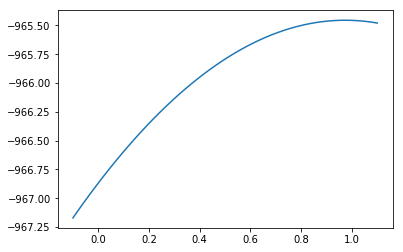

In [11]:
xx = np.linspace(-.1,1.1)
ml = np.zeros_like(xx)
for i in range(len(xx)):
    C_ = C_opt * xx[i] + C * (1 - xx[i])
    ml[i] = Do_Kalman_Likelihood_Bernoulli_And_Gaussian_LaplaceMAP(dN, Y, C_, varY_opt, sigma2e_opt, trials=trials)[2]
plt.plot(xx, ml)
plt.show()

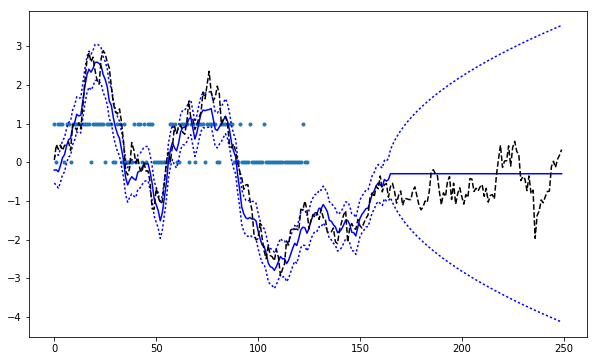

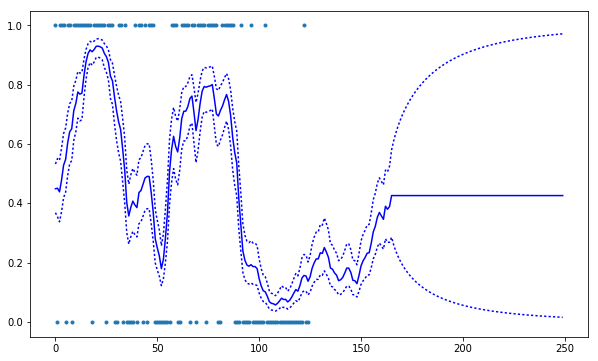

In [12]:
# Test Marginal_Likelihood using the Laplace approximation around the MAP
x_map_l, U_l, marginal_loglikelihood_l, joint_loglikelihood_l = Do_Kalman_Likelihood_Bernoulli_And_Gaussian_LaplaceMAP(dN, Y, C_opt, varY_opt, sigma2e_opt, x0_opt, trials=trials)
plt.figure(figsize=(10,6))
plt.plot(dN, '.')
std = np.sqrt(cov_from_chol_precision(U_l)[1])
x_conf_l = x_map_l[:,None] + [[-1,1]] * std[:,None]
plt.plot(x_map_l, 'b')
plt.plot(x_conf_l, 'b:')
plt.plot(x, 'k--')
plt.show()
plt.figure(figsize=(10,6))
plt.plot(dN, '.')
plt.plot(np.exp(x_map_l)/(1+np.exp(x_map_l)), 'b')
plt.plot(np.exp(x_conf_l) / (1 + np.exp(x_conf_l)), 'b:')
plt.show()